### Get uncorrected bigwigs

In [1]:
import pyBigWig
import pandas as pd
import numpy as np
from load_model import *
import os
import pyfaidx
import one_hot
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#uncorrected_bigwig = "shifted_4_4.sorted.bam.bpnet.unstranded.bw"
#uncorretced_bw = pyBigWig.open(uncorrected_bigwig)

#spi1_bed = "/srv/scratch/anusri/chrombpnet_paper/GM12878/tf_bed/SPI1_task0_peaks.bed"
#spi1_peaks = pd.read_csv(spi1_bed, delimiter="\t").sample(frac=0.001)

reference_genome_path="/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
reader = pyfaidx.Fasta(reference_genome_path)

gc_matched_negs = "/srv/scratch/anusri/chrombpnet_paper/GM12878/negatives_data/bpnet.inputs.all.negatives.bed"
neg_bed=pd.read_csv(gc_matched_negs,delimiter="\t", names=["chr", "start", "end", "name", "score", "strand", "pval", "qval", "qval2", "summit"])
neg_bed.head()

peak_bed_file = "/oak/stanford/groups/akundaje/projects/atlas/atac/caper_out/5846e593-a935-4bd9-9294-422a05f9f9b8/call-reproducibility_idr/glob-1b1244d5baf1a7d98d4b7b76d79e43bf/idr.optimal_peak.narrowPeak.gz"
peak_bed=pd.read_csv(peak_bed_file,delimiter="\t", names=["chr", "start", "end", "name", "score", "strand", "pval", "qval", "qval2", "summit"])

#print(spi1_peaks.shape)
#print(spi1_peaks.head())
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/bias_fit_on_signal_step2/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3_new/"

#path="/srv/scratch/anusri/chrombpnet_paper/tobias_scripts/GM12878/tobias_ATAC_08.03.2021/final_model/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3_new/unplug/"
path="/srv/scratch/anusri/chrombpnet_paper/hint_atac_scripts/GM12878/hintatac_ATAC_07.27.2021/model/"


try:
    model=load_model_wrapper(model_hdf5=path+"model.0.hdf5")
except:
    model=load_model_wrapper(json_string=path+"model.0.arch", weights=path+"model.0.weights")
#output_file="bias_ctcf.pkl"

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
test_nonpeaks = neg_bed[(neg_bed["chr"]=="chr1")]
#test_inpeaks = peak_bed[(peak_bed["chr"]=="chr1")]



In [3]:
def get_seq(genome, peaks_df, width=2114):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)


def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [4]:
test_nonpeaks_seqs = get_seq(reader, test_nonpeaks)



In [5]:
#def profiles_predictions(seqs, model_peaks_corrected):
#    random.shuffle(seqs)
#    
#    w_mot_seqs = seqs.copy()[0:100]
#    
#    predictions = []
#    
#    for i in range(0,100,20):
#        unplug_bias_pred = softmax(model_peaks_corrected.predict([w_mot_seqs[i:i+20]], 
#                                                                       verbose=True)[0])
#        predictions.extend(unplug_bias_pred)
#    
#    return predictions

#print(corrected_model.inputs)

#predictions = profiles_predictions(test_inpeaks_seqs, corrected_model)

#predictions = np.array(predictions).reshape(100,1000)

#import matplotlib.pyplot as plt
#plt.plot(predictions[0,:])



In [6]:
import random
random.seed(1)

num=17851
#num=100
    
def profiles_for_motif(seqs, motif, model_peaks_corrected):
    random.shuffle(seqs)
  
    w_mot_seqs = seqs.copy()[0:num]
    w_mot_seqs[:, 1057:1057+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    predictions = []
    
    for i in range(0,num,100):
        unplug_bias_pred = softmax(model_peaks_corrected.predict([w_mot_seqs[i:i+100]], 
                                                                       verbose=True)[0])
        predictions.extend(unplug_bias_pred)
    
    return predictions

In [7]:
def plot_tracks(pred_unplug_bias, start=500-100+5, end=500+100+5):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0))
    plt.ylim(0,0.002)
    plt.legend()
    plt.show()

In [8]:
#pred_unplug_bias = profiles_for_motif(test_nonpeaks_seqs, "GCGCATGCGC", model)
#CAGTACAGAGCTG
#ctcf-CCACTAGGGGGCG

import pickle as pkl
#from scipy.special import softmax

#data = pkl.load(open("/srv/scratch/anusri/chrombpnet_paper/tobias_scripts/GM12878/actual_tobias_files/GM12878.atac.filt.merged_AtacBias.pickle", "rb"))
#tobias_atac_pssm_forward=np.expand_dims(np.transpose(data.bias['forward'].pssm[0:4])[:,[0,2,3,1]],axis=-1)
#tn5_motif = softmax(tobias_atac_pssm_forward.reshape(25,4),axis=1)
#tn5_motif="CAGNNCAGNNCAG"
#tn5_motif=pkl.load(open("/srv/scratch/anusri/chrombpnet_paper/main_scripts/modisco/pattern_0.cwm.rev.pkl", "rb"))
#print(tn5_motif)

tn5_motif="GATGG"
pred_unplug_bias = profiles_for_motif(test_nonpeaks_seqs, tn5_motif , model)




Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


No handles with labels found to put in legend.


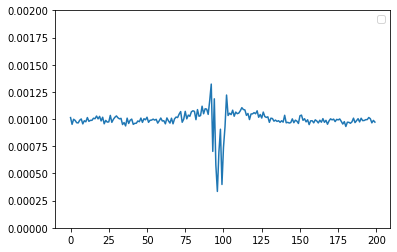

In [9]:
import matplotlib
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline
plot_tracks(np.array(pred_unplug_bias).reshape(num,1000))

#print(pred_unplug_bias)





In [10]:
import pickle as pkl

#pkl.dump(pred_unplug_bias, open(output_file, "wb"))



